# 誘導点に対する Relevance Vector Machine (Stochastic Variational Sparse Gaussian Process)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VSGP
from kernels import RBF
from kernels import RVM
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

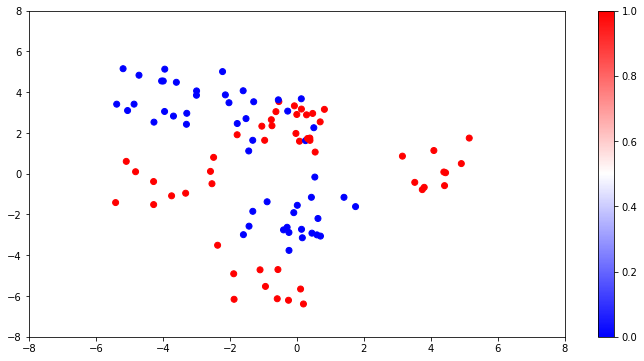

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle = True)

likelihood = Binary()
Z = X[:20, :].clone()
kernel = RVM(RBF(), Z)
estimator = VSGP(Z, 1, kernel, likelihood, whiten = True)
estimator.kernel.X = estimator.Z

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_epochs = 300
for epoch in range(n_epochs):
    for batch_X, batch_y in dataloader:
        loss = svi.step(batch_X, batch_y, num_data = X.shape[0])
    if epoch % (n_epochs / 10) == 0:
        print(loss)

104.29006607836772
51.31843314458132
24.392354465187964
33.81089202659399
21.490529326998
36.23611774510914
58.93610789335963
22.214755154594172
25.95344056935801
24.96227737578056


---

## 推論結果

### 予測分布

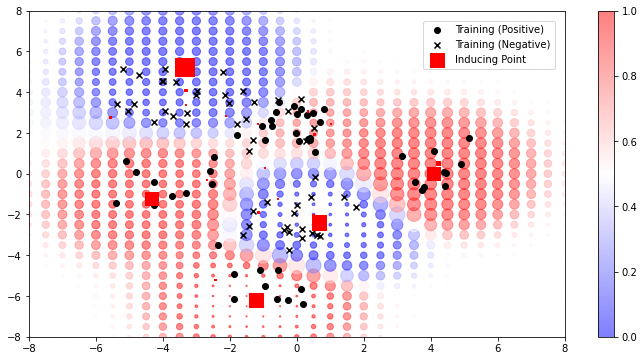

CPU times: user 8.13 s, sys: 430 ms, total: 8.56 s
Wall time: 2.4 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)
    
    sr = estimator.kernel.relevance
    sr = (sr - sr.min()) / sr.std() * 100 + 1
    sp = pnew_std[:, 0]
    sp = ((sp - sp.min()) / sp.std()) * 50 + 1

    plt.figure(figsize = (12, 6))
    plt.scatter(
        x = Xnew[:, 0], y = Xnew[:, 1],
        s = sp,
        c = pnew_mean[:, 0], cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5,
        marker = "o"
    )
    plt.colorbar()
    plt.scatter(
        x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1],
        c = "black",
        marker = "o",
        label = "Training (Positive)"
    )
    plt.scatter(
        x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1],
        c = "black",
        marker = "x",
        label = "Training (Negative)"
    )
    plt.scatter(
        x = estimator.Z[:, 0], y = estimator.Z[:, 1],
        s = sr,
        c = "red",
        marker = "s",
        label = "Inducing Point"
    )
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend(bbox_to_anchor = (1, 1), loc = "upper right", borderaxespad = 1)
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.relevance

tensor([3.9170e-01, 2.0728e+00, 1.9556e+02, 1.8672e-01, 4.9620e-01, 6.0679e+00,
        8.0548e-01, 1.4889e+00, 7.2196e-01, 5.8257e-01, 3.5640e-01, 4.0120e+02,
        1.6658e+01, 8.5098e-01, 1.8784e+02, 2.5309e-01, 2.3613e+02, 2.4079e+02,
        1.7008e+00, 4.8819e+00], grad_fn=<AddBackward0>)

In [11]:
estimator.kernel.kernel.scale

tensor(1.4115, grad_fn=<AddBackward0>)

### 変分パラメーター

In [12]:
estimator.Z

Parameter containing:
tensor([[-1.1644,  2.4856],
        [-5.5716,  2.7844],
        [ 4.0890,  0.0330],
        [-0.9652,  0.3047],
        [-2.7061, -0.2769],
        [-3.3198,  4.1186],
        [-2.4441, -5.1896],
        [-0.5779, -1.2211],
        [ 0.3265,  3.0753],
        [-1.1589, -1.8795],
        [ 1.0082,  2.4617],
        [-3.3485,  5.2236],
        [ 4.2050,  0.5129],
        [-3.3212,  3.4054],
        [-4.3369, -1.2278],
        [-2.1238,  2.8369],
        [-1.2299, -6.2043],
        [ 0.6675, -2.3890],
        [ 0.5158,  1.9444],
        [ 0.4944, -2.0333]], requires_grad=True)

In [13]:
estimator.u_loc

Parameter containing:
tensor([[-8.7977e-04, -1.0110e+00,  9.9306e-01, -4.2776e-01,  1.2881e+00,
         -1.2868e+00,  1.2284e+00, -7.5503e-01,  5.3101e-01, -1.2030e-01,
         -4.0501e-02,  6.7140e-02,  4.1744e-02,  6.3415e-03,  5.6773e-02,
          4.9022e-02,  6.4233e-02,  5.1952e-02, -1.1594e-02, -2.9330e-02]],
       requires_grad=True)

In [14]:
estimator.u_cov

tensor([[[ 1.0281e-01, -4.1934e-02, -1.9864e-02, -1.6148e-03, -4.4762e-02,
          -2.1952e-02, -1.1171e-02,  2.5792e-02, -1.4143e-01, -2.8757e-02,
          -5.3338e-02,  3.8673e-02, -8.0815e-03, -8.0482e-03,  3.0426e-02,
          -5.8845e-03,  3.1688e-02,  4.8795e-02,  4.2165e-02, -2.8438e-02],
         [-4.1934e-02,  5.2113e-01,  3.2891e-02,  7.4386e-02, -3.8373e-02,
          -3.4047e-01,  1.9374e-02, -1.7075e-02,  4.7057e-02,  4.5614e-02,
           1.9150e-02, -1.6837e-02, -5.0924e-03,  2.4016e-02,  1.1811e-02,
          -5.2423e-02, -1.1274e-01, -7.4550e-02,  9.5773e-02, -1.2122e-02],
         [-1.9864e-02,  3.2891e-02,  1.6555e-01, -2.9561e-02,  7.5253e-03,
           2.5302e-02,  3.1501e-02, -2.6596e-02,  3.8384e-02, -1.9817e-02,
          -2.0329e-02, -4.2032e-03,  2.3408e-02, -3.7120e-02,  4.3657e-02,
          -1.1803e-02, -5.8806e-03,  2.8879e-02, -2.2787e-02, -2.0192e-02],
         [-1.6148e-03,  7.4386e-02, -2.9561e-02,  2.9427e-01, -7.7145e-02,
          -1.7641e-02,